In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns

In [2]:
#wdir = '../../../Dropbox/Research/covid_19/uk/processed'
wdir = '../data/processed'

In [11]:
df_all = pd.read_csv(wdir + '/deaths_2020_wk13.csv').iloc[:13,:].reset_index(drop=True).copy(deep=True)
df_all = df_all[['week', 'week_ended', 'total_deaths_all_ages', 'total_deaths_avg_corresponding_5', 'respitory_deaths', 'london', 'south_east']]

df_covid = pd.read_csv(wdir + '/deaths_2020_wk13_covid.csv').iloc[:13,:].reset_index(drop=True).copy(deep=True)
df_covid = df_covid[['week', 'covid_deaths', 'london', 'south_east']]
df_covid.columns = ['week', 'covid_deaths', 'london_covid', 'south_east_covid']
df_all = pd.merge(df_all, df_covid, on=['week'], how='inner').iloc[10:,:].reset_index(drop=True).copy(deep=True)

In [12]:
for y in range(2015, 2020):
    df_y = pd.read_csv(wdir + '/deaths_{}.csv'.format(y)).iloc[:13,:].reset_index(drop=True)[['week', 'london']].copy(deep=True)
    df_y.columns = ['week', 'london_{}'.format(y)]
    df_y_alldeath = pd.read_csv(wdir + '/deaths_{}.csv'.format(y)).iloc[:13,:].reset_index(drop=True)[['week', 'total_deaths_all_ages']].copy(deep=True)
    df_y_alldeath.columns = ['week', 'total_deaths_all_ages_{}'.format(y)]
    
    if y == 2015:
        df_lon = df_y.copy(deep=True)
        df_alldeath = df_y_alldeath.copy(deep=True)
    else:
        df_lon = pd.merge(df_lon, df_y, on=['week'], how='inner')
        df_alldeath = pd.merge(df_alldeath, df_y_alldeath, on=['week'], how='inner')
df_lon['lon_avg'] = (df_lon.london_2015 + df_lon.london_2016 + df_lon.london_2017 + df_lon.london_2018 + df_lon.london_2019) / 5
df_alldeath['alldeath_avg'] = (df_alldeath.total_deaths_all_ages_2015 + df_alldeath.total_deaths_all_ages_2016 + df_alldeath.total_deaths_all_ages_2017 + df_alldeath.total_deaths_all_ages_2018 + df_alldeath.total_deaths_all_ages_2019) / 5
#df_lon = df_lon[['week', 'lon_avg']]
df = pd.merge(df_all, df_lon, on=['week'], how='inner')
df = pd.merge(df, df_alldeath, on=['week'], how='inner')


In [13]:
for i in range(2015, 2020):
    df['cs_london_{}'.format(i)] = df['london_{}'.format(i)].cumsum()
    df['cs_total_deaths_all_ages_{}'.format(i)] = df['total_deaths_all_ages_{}'.format(i)].cumsum()
    del df['london_{}'.format(i)]
    del df['total_deaths_all_ages_{}'.format(i)]


In [14]:
#compute growth rates
for yr in range(2015, 2020):
    df['gr_lon_{}'.format(yr)] = df['cs_london_{}'.format(yr)] / df['cs_london_{}'.format(yr)].shift(1)
    df['gr_all_{}'.format(yr)] = df['cs_total_deaths_all_ages_{}'.format(yr)] / df['cs_total_deaths_all_ages_{}'.format(yr)].shift(1)
    del df['cs_london_{}'.format(yr)]
    del df['cs_total_deaths_all_ages_{}'.format(yr)]

In [15]:
#compute average of growth rates
df['weekly_growth_lon'] = df.loc[:,['gr_lon_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df['weekly_growth_all'] = df.loc[:,['gr_all_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_all_{}'.format(yr) for yr in range(2015,2020)], axis=1)
df = df.drop(['gr_lon_{}'.format(yr) for yr in range(2015,2020)], axis=1)
df

,week,week_ended,total_deaths_all_ages,total_deaths_avg_corresponding_5,respitory_deaths,london,south_east,covid_deaths,london_covid,south_east_covid,lon_avg,alldeath_avg,weekly_growth_lon,weekly_growth_all
0,11,2020-03-13 00:00:00,11019.0,11205.0,1488.0,964.0,1751.0,5.0,0.0,2.0,1034.0,11205.0,NaN,NaN
1,12,2020-03-20 00:00:00,10645.0,10573.0,1514.0,1008.0,1657.0,103.0,44.0,17.0,988.4,10568.6,1.955967,1.944075
2,13,2020-03-27 00:00:00,11141.0,10130.0,1534.0,1297.0,1822.0,539.0,237.0,69.0,965.4,10122.8,1.478625,1.467108


In [16]:
df['cs_total'] = df.total_deaths_all_ages.cumsum()
df['cs_london'] = df.london.cumsum()

df['tot_extrap'] = 0
df['lon_extrap'] = 0

df.loc[0, 'tot_extrap'] = df.cs_total[0]
df.loc[0, 'lon_extrap'] = df.cs_london[0]

for i in range(1, df.shape[0]):
    df.loc[i, 'tot_extrap'] = df.loc[i-1, 'tot_extrap'] * df.loc[i, 'weekly_growth_all']
    df.loc[i, 'lon_extrap'] = df.loc[i-1, 'lon_extrap'] * df.loc[i, 'weekly_growth_lon']
    
df['tot_extrap_covid'] = df.tot_extrap + df.covid_deaths
df['lon_extrap_covid'] = df.lon_extrap + df.london_covid

   week           week_ended  total_deaths_all_ages  \
0    11  2020-03-13 00:00:00                11019.0   
1    12  2020-03-20 00:00:00                10645.0   
2    13  2020-03-27 00:00:00                11141.0   

   total_deaths_avg_corresponding_5  respitory_deaths  london  south_east  \
0                           11205.0            1488.0   964.0      1751.0   
1                           10573.0            1514.0  1008.0      1657.0   
2                           10130.0            1534.0  1297.0      1822.0   

   covid_deaths  london_covid  south_east_covid  lon_avg  alldeath_avg  \
0           5.0           0.0               2.0   1034.0       11205.0   
1         103.0          44.0              17.0    988.4       10568.6   
2         539.0         237.0              69.0    965.4       10122.8   

   weekly_growth_lon  weekly_growth_all  cs_total  cs_london    tot_extrap  \
0                NaN                NaN   11019.0      964.0  11019.000000   
1           1.955

In [17]:
df_all = df[['week', 'week_ended', 'covid_deaths', 'cs_total', 'tot_extrap', 'tot_extrap_covid']].copy(deep=True)
df_all.columns = ['week', 'week_ended', 'covid_deaths', 'deaths_2020', '2020_counterfactual', 'counterfactual_plus_covid']
df_all

,week,week_ended,covid_deaths,deaths_2020,2020_counterfactual,counterfactual_plus_covid
0,11,2020-03-13 00:00:00,5.0,11019.0,11019.000000,11024.000000
1,12,2020-03-20 00:00:00,103.0,21664.0,21421.756954,21524.756954
2,13,2020-03-27 00:00:00,539.0,32805.0,31428.030107,31967.030107


In [18]:
df_all.to_csv(wdir + '/_extrap_englandwales_2_weeks_from_week11.csv', index=False)

In [19]:
df_lon = df[['week', 'week_ended', 'london_covid', 'cs_london', 'lon_extrap', 'lon_extrap_covid']].copy(deep=True)
df_lon.columns = ['week', 'week_ended', 'covid_deaths', 'deaths_2020', '2020_counterfactual', 'counterfactual_plus_covid']
df_lon

,week,week_ended,covid_deaths,deaths_2020,2020_counterfactual,counterfactual_plus_covid
0,11,2020-03-13 00:00:00,0.0,964.0,964.000000,964.000000
1,12,2020-03-20 00:00:00,44.0,1972.0,1885.551884,1929.551884
2,13,2020-03-27 00:00:00,237.0,3269.0,2788.024425,3025.024425


In [20]:
df_lon.to_csv(wdir + '/_extrap_london_2_weeks_from_week11.csv', index=False)

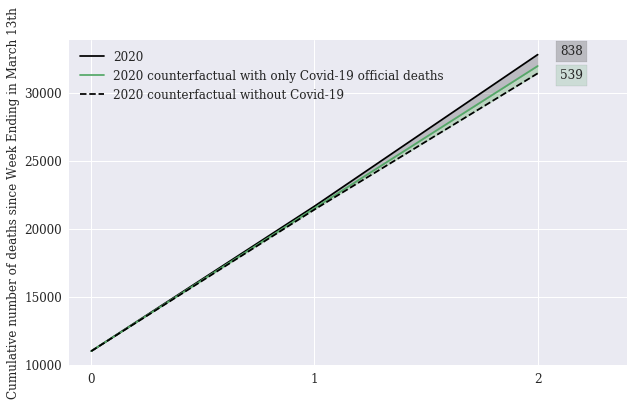

In [21]:
dffig =df[['cs_total', 'tot_extrap', 'tot_extrap_covid']].copy(deep=True)
dffig.columns = ['cs_2020', 'counterfactual', 'counterfactual_2020_covid']
dffig.index=df.index

palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(dffig.index,
        dffig['cs_2020'],
        label='2020',
        color='black')
ax.plot(dffig.index,
        dffig['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(dffig.index,
        dffig['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(dffig.index[[0,1,2]])
ax.fill_between(dffig.index, dffig['cs_2020'], dffig['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(dffig.index, dffig['counterfactual_2020_covid'], dffig['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since Week Ending in March 13th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.3

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(2.1, 31000, '{}'.format(int(round(dffig.iloc[-1, 2] - dffig.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)

plt.text(2.1, 32800, '{}'.format(int(round(dffig.iloc[-1, 0] - dffig.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig(wdir+'Fig_englandwales.png', bbox_inches='tight', dpi=100)


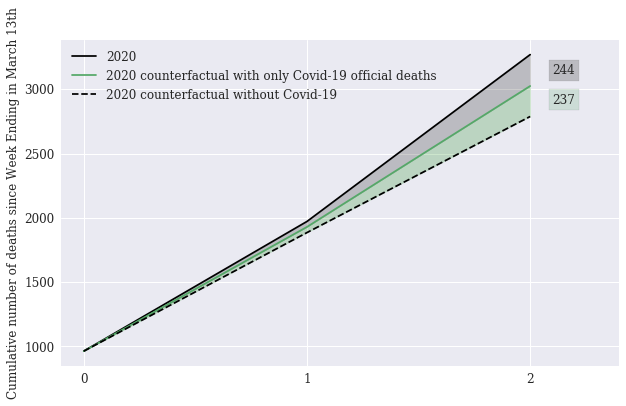

In [22]:
dffig =df[['cs_london', 'lon_extrap', 'lon_extrap_covid']].copy(deep=True)
dffig.columns = ['cs_2020', 'counterfactual', 'counterfactual_2020_covid']
dffig.index=df.index

palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(dffig.index,
        dffig['cs_2020'],
        label='2020',
        color='black')
ax.plot(dffig.index,
        dffig['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(dffig.index,
        dffig['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(dffig.index[[0,1,2]])
ax.fill_between(dffig.index, dffig['cs_2020'], dffig['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(dffig.index, dffig['counterfactual_2020_covid'], dffig['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since Week Ending in March 13th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.3

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(2.1, 2890, '{}'.format(int(round(dffig.iloc[-1, 2] - dffig.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)

plt.text(2.1, 3120, '{}'.format(int(round(dffig.iloc[-1, 0] - dffig.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig(wdir+'Fig_London.png', bbox_inches='tight', dpi=100)
